# Recommender System - Model Development
This notebook demonstrates building a recommendation system on the Amazon Reviews 2023 dataset. It includes data loading, preprocessing, model training, evaluation, and generating sample recommendations. The dataset is sourced from the Hugging Face datasets library [Amazon Reviews 2023](https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023) based on paper [Bridging Language and Items for Retrieval and Recommendation (2024)](
https://doi.org/10.48550/arXiv.2403.03952
).

In [1]:
import os
import random
import numpy as np
import pandas as pd
import time
import gc
import matplotlib.pyplot as plt
from collections import defaultdict

#
# os.environ["HF_HOME"] = "D:/Python Projects/recommendation_system"
# os.environ["HF_DATASETS_CACHE"] = "D:/Python Projects/recommendation_system/recsys/data"
# os.environ["TRANSFORMERS_CACHE"] = "D:/Python Projects/recommendation_system/recsys/models"

os.environ["HF_HOME"] = "E:/Python Scripts/recsys"
os.environ['HF_DATASETS_CACHE'] = "E:/Python Scripts/recsys/data"
os.environ['TRANSFORMERS_CACHE'] = "E:/Python Scripts/recsys/models"

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from datasets import load_dataset, Features, Value
from tqdm import tqdm
from tensorboardX import SummaryWriter

E:\Python Scripts\recsys\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 42
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

DEVICE: cuda


## Loading the dataset
The dataset is loaded from the Hugging Face datasets library, Amazon Reviews 2023.

In [3]:
USE_HF = True
HF_DATASET = "McAuley-Lab/Amazon-Reviews-2023"
HF_DOMAIN = "Movies_and_TV"   # choose your domain

def load_amazon_reviews_fast(domain: str, max_items: int | None = None, seed: int = SEED) -> pd.DataFrame:
    ds = load_dataset(
        "McAuley-Lab/Amazon-Reviews-2023",
        f"raw_review_{domain}",
        split="full",
        trust_remote_code=True,
    )

    # Keep only needed columns early
    ds = ds.select_columns(["user_id", "parent_asin", "rating", "verified_purchase", "timestamp"])

    # Rename + cast in Arrow (vectorized; no Python loop)
    ds = ds.rename_columns({"user_id": "user", "parent_asin": "item"})
    ds = ds.cast(Features({
        "user": Value("string"),
        "item": Value("string"),
        "rating": Value("float32"),
        "verified_purchase": Value("bool"),
        "timestamp": Value("int64"),   # seconds or ms as stored
    }))

    # Fast random subset without building a huge pandas frame first
    if max_items is not None:
        k = min(max_items, ds.num_rows)
        ds = ds.shuffle(seed=seed).select(range(k))

    # Convert to pandas (Arrow zero-copy where possible)
    df = ds.to_pandas()
    df.insert(3, "domain", domain)
    return df

df = load_amazon_reviews_fast(HF_DOMAIN, max_items=3_000_000, seed=SEED)
print(f"Loaded {len(df)} rows from {HF_DOMAIN} domain.")

Loaded 3000000 rows from Movies_and_TV domain.


In [4]:
df.head()

,user,item,rating,domain,verified_purchase,timestamp
0,AHHW42C67LCCUCLF7M7SBLDVKTQQ,B07XZD2RR4,5.0,Movies_and_TV,True,1570937908945
1,AEJQ3S7S5O6LBPMQLOBYUBPMECDQ,B000KF0GRW,5.0,Movies_and_TV,True,1173388138000
2,AFZCEV4OHBOSOT226R7INKPRGYWQ,B00104AYSS,5.0,Movies_and_TV,True,1424845397000
3,AGEDLCCEVKIPMM4MY6U33KANA3IA,B003YVEIY6,5.0,Movies_and_TV,False,1409109366000
4,AFB6GRGUSPQWO7XXQG5ANLYQGLSA,B00ZGUUTN2,5.0,Movies_and_TV,True,1456348687000


## Preprocessing the dataset
- Make it implicit by considering all ratings as positive interactions.
- Filter out users and items with less than 5 interactions.
- Create a mapping of user and item IDs to indices.

In [5]:
# Make implicit dataset, filter users/items with less than 5 interactions, and encode user/item IDs
def preprocess_dataset(df, min_user_interactions=5, min_item_interactions=5):
    # Make it implicit
    df["label"] = 1.0
    # Filter users and items with less than 5 interactions
    user_counts = df["user"].value_counts()
    item_counts = df["item"].value_counts()
    valid_users = user_counts[user_counts >= min_user_interactions].index
    valid_items = item_counts[item_counts >= min_item_interactions].index
    df = df[df["user"].isin(valid_users) & df["item"].isin(valid_items)].copy()
    print("After interactions filtering:", len(df), "rows,", df["user"].nunique(), "users,", df["item"].nunique(), "items")
    return df

def label_encoder(df):
    user_enc = LabelEncoder()
    item_enc = LabelEncoder()
    df["user_id"] = user_enc.fit_transform(df["user"])
    df["item_id"] = item_enc.fit_transform(df["item"])
    return {"encoded_df": df,
            "user_encoder": user_enc,
            "item_encoder": item_enc}

filtered_df = preprocess_dataset(df, min_user_interactions=20, min_item_interactions=20)
le = label_encoder(filtered_df)
filtered_df = le["encoded_df"]
user_enc = le["user_encoder"]
item_enc = le["item_encoder"]

After interactions filtering: 45959 rows, 3286 users, 17003 items


In [6]:
def calculate_data_sparsity(df):
    num_users = df["user"].nunique()
    num_items = df["item"].nunique()
    num_interactions = len(df)
    density = num_interactions / (num_users * num_items)
    sparsity = 1 - density

    print(f"Number of users: {num_users}")
    print(f"Number of items: {num_items}")
    print(f"Number of interactions: {num_interactions}")
    print(f"-" * 30)
    print(f"Interaction Matrix Density: {density:.6f}")
    print(f"Interaction Matrix Sparsity: {sparsity:.6f}")

calculate_data_sparsity(filtered_df)

Number of users: 3286
Number of items: 17003
Number of interactions: 45959
------------------------------
Interaction Matrix Density: 0.000823
Interaction Matrix Sparsity: 0.999177


In [7]:
def loo_split(df, oversample_verified=False, oversample_factor=2):
    df = df.sort_values(["user_id", "timestamp"])
    train_rows, val_rows, test_rows = [], [], []
    for uid, group in df.groupby("user_id", sort=False):
        g = group.sort_values("timestamp")
        if len(g) < 5:
            train_rows.append(g)
            continue
        test_rows.append(g.iloc[[-1]])  # Last interaction as test
        val_rows.append(g.iloc[[-2]])    # Second last interaction as validation
        train_rows.append(g.iloc[:-2])    # All but last two as training

    train_df = pd.concat(train_rows, ignore_index=True)
    val_df = pd.concat(val_rows, ignore_index=True)
    test_df = pd.concat(test_rows, ignore_index=True)

    if oversample_verified and oversample_factor > 1:
        verified_rows = train_df.loc[train_df["verified_purchase"] == True]
        if not verified_rows.empty:
            train_df = pd.concat([train_df] + [verified_rows] * (oversample_factor - 1), ignore_index=True)

    return train_df, val_df, test_df

train_df, val_df, test_df = loo_split(filtered_df, oversample_verified=False, oversample_factor=1)
print(f"Train/Validation/Test split: {len(train_df)}, {len(val_df)}, {len(test_df)}")

Train/Validation/Test split: 40119, 2920, 2920


## Building the dataset with negative sampling

In [8]:
NUM_USERS = filtered_df["user_id"].max() + 1
NUM_ITEMS = filtered_df["item_id"].max() + 1

In [9]:
# Rank the single positive against k negative samples for train and evaluation
def build_pos_items_by_user(train_df):
    pos_items_by_user = defaultdict(set)
    for u, i in zip(train_df["user_id"].values, train_df["item_id"].values):
        pos_items_by_user[u].add(int(i))
    return pos_items_by_user

In [10]:
# Training dataset with k negatives per positive
class ImplicitTrainingDataset(Dataset):
    def __init__(self, train_df, num_items, pos_by_user, neg_k=4, seed=SEED):
        self.pos_pairs = train_df[["user_id", "item_id"]].values.astype(np.int64)
        self.num_pos = len(self.pos_pairs)
        self.neg_k = neg_k
        self.num_items = num_items
        self.pos_by_user = pos_by_user
        self.length = self.num_pos * (1 + self.neg_k)
        self.rng = random.Random(seed)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        pos_idx = idx // (self.neg_k + 1)
        is_pos = (idx % (self.neg_k + 1) == 0)
        u, i_pos = self.pos_pairs[pos_idx]
        if is_pos:
            return int(u), int(i_pos), 1.0

        while True:
            j = self.rng.randint(0, self.num_items - 1)
            if j not in self.pos_by_user[u]:
                return int(u), int(j), 0.0

pos_items_by_user = build_pos_items_by_user(train_df)

train_dataset = ImplicitTrainingDataset(train_df,
                                  num_items=NUM_ITEMS,
                                  pos_by_user=pos_items_by_user,
                                  neg_k=4)
train_loader = DataLoader(train_dataset,
                          batch_size=4096,
                          shuffle=True)

print(f"Training dataset created with {len(train_dataset)} samples.")

Training dataset created with 200595 samples.


In [11]:
class EvaluateDataset(Dataset):
    def __init__(self, eval_df, num_items, pos_by_user, n_neg=99, seed=42):
        self.users = eval_df["user_id"].values.astype(np.int64)
        self.pos_items = eval_df["item_id"].values.astype(np.int64)
        self.n_neg = n_neg
        self.num_items = num_items
        self.pos_by_user = pos_by_user

        rng = np.random.default_rng(seed)
        self.candidates = np.empty((len(self.users), 1 + n_neg), dtype=np.int64)

        for idx, (u, pos_i) in enumerate(zip(self.users, self.pos_items)):
            user_pos = pos_by_user[u].copy()
            user_pos.add(pos_i)
            negs = []
            while len(negs) < n_neg:
                neg = rng.integers(0, num_items)
                if neg not in user_pos:
                    negs.append(int(neg))
                    user_pos.add(neg)
            self.candidates[idx, 0] = pos_i
            self.candidates[idx, 1:] = np.asarray(negs, dtype=np.int64)

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        return int(self.users[idx]), self.candidates[idx]

# Build val/test loaders
val_dataset = EvaluateDataset(val_df, NUM_ITEMS, pos_items_by_user, n_neg=99, seed=SEED)
test_dataset = EvaluateDataset(test_df, NUM_ITEMS, pos_items_by_user, n_neg=99, seed=SEED)

val_loader = DataLoader(val_dataset, batch_size=4096, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4096, shuffle=False)

print(f"Validation dataset: {len(val_dataset)} users")
print(f"Test dataset: {len(test_dataset)} users")

Validation dataset: 2920 users
Test dataset: 2920 users


In [12]:
# Training dataset with k negatives per positive
class CustomDataset(Dataset):
    def __init__(self, df, num_items, pos_by_user, n_neg=4, mode="train", seed=SEED):
        self.pos_pairs = df[["user_id", "item_id"]].values.astype(np.int64)
        self.users = self.pos_pairs[:, 0]
        self.pos_items = self.pos_pairs[:, 1]
        self.num_items = num_items
        self.n_neg = n_neg
        self.mode = mode
        self.pos_by_user = pos_by_user
        self.rng = np.random.default_rng(seed)

        if mode == "val" or mode == "test":
            self.eval_candidates = np.empty((len(self.users), 1 + self.n_neg), dtype=np.int64)
            for idx, (u, pos_i) in enumerate(zip(self.users, self.pos_items)):
                user_pos = self.pos_by_user[u].copy()
                user_pos.add(pos_i)
                negs = []
                while len(negs) < self.n_neg:
                    neg = self.rng.integers(0, self.num_items)
                    if neg not in user_pos:
                        negs.append(int(neg))
                        user_pos.add(neg)
                self.eval_candidates[idx, 0] = pos_i
                self.eval_candidates[idx, 1:] = np.asarray(negs, dtype=np.int64)

    def __len__(self):
        return len(self.pos_pairs) * (1 + self.n_neg) if self.mode == "train" else len(self.users)

    def __getitem__(self, idx):
        if self.mode == "train":
            return self._get_train_item(idx)
        else:
            return self._get_eval_item(idx)

    def _get_train_item(self, idx):
        pos_idx = idx // (self.n_neg + 1)
        is_pos = (idx % (self.n_neg + 1) == 0)
        u, i_pos = self.pos_pairs[pos_idx]
        if is_pos:
            return int(u), int(i_pos), 1.0

        while True:
            j = self.rng.integers(0, self.num_items - 1)
            if j not in self.pos_by_user[u]:
                return int(u), int(j), 0.0

    def _get_eval_item(self, idx):
        return int(self.users[idx]), self.eval_candidates[idx]


pos_items_by_user = build_pos_items_by_user(train_df)

train_dataset = CustomDataset(train_df, num_items=NUM_ITEMS, pos_by_user=pos_items_by_user, n_neg=4, mode="train", seed=SEED)
train_loader = DataLoader(train_dataset, batch_size=4096, shuffle=True)

val_dataset = CustomDataset(val_df, num_items=NUM_ITEMS, pos_by_user=pos_items_by_user, n_neg=99, mode="val", seed=SEED)
val_loader = DataLoader(val_dataset, batch_size=4096, shuffle=False)

test_dataset = CustomDataset(test_df, num_items=NUM_ITEMS, pos_by_user=pos_items_by_user, n_neg=99, mode="test", seed=SEED)
test_loader = DataLoader(test_dataset, batch_size=4096, shuffle=False)

print(f"Training dataset created with {len(train_dataset)} samples.")
print(f"Validation dataset created with {len(val_dataset)} samples.")
print(f"Test dataset created with {len(test_dataset)} samples.")

Training dataset created with 200595 samples.
Validation dataset created with 2920 samples.
Test dataset created with 2920 samples.


## Utility functions for training and evaluation
- Train one epoch
- For each val user, build candidate set = `{positive} U {k negatives}`
- Score, sort, compute HR@K, NDCG@K, Precision@K, MAP@K

In [13]:
def train_epoch(model, train_loader, loss_fn, optimizer, device="cpu"):
    model.train()
    running_loss = 0.0
    n_batches = 0

    for batch in tqdm(train_loader, desc="Training"):
        users, items, labels = batch
        users = users.to(device, non_blocking=True)
        items = items.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(users, items)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        n_batches += 1

    epoch_loss = running_loss / max(n_batches, 1)
    return epoch_loss

In [14]:
# Validation loss and ranking metrics
@torch.no_grad()
def evaluate(model, eval_loader, loss_fn, k=10, device="cpu"):
    model.eval()
    total = 0
    sum_hr = 0.0
    sum_ndcg = 0.0
    sum_prec = 0.0
    sum_ap = 0.0

    sum_val_loss = 0.0
    n_loss_batches = 0

    for users, cand in tqdm(eval_loader, desc="Evaluating"):
        users = users.to(device, non_blocking=True)
        cand = torch.as_tensor(cand, dtype=torch.long, device=device)
        B, C = cand.shape

        # Repeat users per candidate, score in one forward
        users_rep = users.view(-1, 1).expand(-1, C).reshape(-1)
        items_flat = cand.reshape(-1)
        scores_flat = model(users_rep, items_flat)
        scores = scores_flat.view(B, C)

        # Rank of the positive (column 0)
        pos = scores[:, 0].unsqueeze(1)  # [B,1]
        # number of items with strictly greater score than the positive +1
        rank = (scores[:, 1:] > pos).sum(dim=1).add_(1).to(torch.long)  # [B]

        hit = (rank <= k).float()
        ndcg = torch.where(rank <= k, 1.0 / torch.log2(rank.float() + 1), torch.zeros_like(hit))
        precision = hit / float(k)
        ap = torch.where(rank <= k, 1.0 / rank.float(), torch.zeros_like(hit))

        sum_hr += hit.sum().item()
        sum_ndcg += ndcg.sum().item()
        sum_prec += precision.sum().item()
        sum_ap += ap.sum().item()
        total += B

        # Validation loss: labels = [1, 0, 0, ...]
        labels = torch.zeros_like(scores)
        labels[:, 0] = 1.0
        batch_loss = loss_fn(scores, labels)
        sum_val_loss += batch_loss.item()
        n_loss_batches += 1

    metrics = {
        "HR@K": sum_hr / total if total else 0.0,
        "NDCG@K": sum_ndcg / total if total else 0.0,
        "Precision@K": sum_prec / total if total else 0.0,
        "MAP@K": sum_ap / total if total else 0.0,
        "Val loss": sum_val_loss / max(n_loss_batches, 1)
    }
    return metrics

## Train loop

In [15]:
def model_trainer(
        model,
        train_loader,
        eval_loader,
        epochs,
        loss_fn,
        optimizer,
        k=10,             # kept to log hyperparams
        device="cpu",
        save_dir="model"
    ):
    os.makedirs(save_dir, exist_ok=True)
    model.to(device)
    writer = SummaryWriter()

    train_losses, val_losses, val_metrics_log = [], [], []
    best_ndcg, best_epoch = 0.0, 0

    for epoch in range(epochs):
        t0 = time.time()

        # Train (batched)
        train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device=device)
        train_losses.append(train_loss)

        # Eval (batched)
        m = evaluate(model, eval_loader, loss_fn, k=k, device=device)
        val_losses.append(m["Val loss"])
        val_metrics_log.append({k_: m[k_] for k_ in ["HR@K", "NDCG@K", "Precision@K", "MAP@K"]})

        # Checkpointing by NDCG
        if m["NDCG@K"] > best_ndcg:
            best_ndcg = m["NDCG@K"]
            best_epoch = epoch + 1
            torch.save(model.state_dict(), os.path.join(save_dir, "best_model.pth"))
        torch.save(model.state_dict(), os.path.join(save_dir, "last_model.pth"))

        # TB logs
        writer.add_scalar("Loss/Train", train_loss, epoch)
        writer.add_scalar("Loss/Validation", m["Val loss"], epoch)
        writer.add_scalar(f"Metrics/Val_HR@{k}", m["HR@K"], epoch)
        writer.add_scalar(f"Metrics/Val_NDCG@{k}", m["NDCG@K"], epoch)
        writer.add_scalar(f"Metrics/Val_Precision@{k}", m["Precision@K"], epoch)
        writer.add_scalar(f"Metrics/Val_MAP@{k}", m["MAP@K"], epoch)

        print(
            f"Epoch {epoch+1}/{epochs}  "
            f"Train loss {train_loss:.4f}  "
            f"Val loss {m['Val loss']:.4f}  "
            f"HR@{k} {m['HR@K']:.4f}  "
            f"NDCG@{k} {m['NDCG@K']:.4f}  "
            f"Precision@{k} {m['Precision@K']:.4f}  "
            f"MAP@{k} {m['MAP@K']:.4f}  "
            f"{'(new best)' if m['NDCG@K'] == best_ndcg and best_epoch==epoch+1 else ''}  "
            f"Time {time.time()-t0:.2f}s"
        )

    # print("\n" + "="*50)
    print("\nTraining Complete.")
    print(f"Best epoch: {best_epoch} with NDCG@{k}: {best_ndcg:.4f}\n")
    # print("="*50)
    # print("\n")

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    writer.close()
    return train_losses, val_losses, val_metrics_log, best_ndcg

## Baseline model: Matrix factorization

A simple Matrix Factorization model with user and item embeddings with dot product scoring.

In [16]:
# Simple Matrix Factorization model (dot product)
class MatrixFactorization(nn.Module):
    def __init__(self, n_users, n_items, embedding_dim):
        super().__init__()
        self.user_embed = nn.Embedding(n_users, embedding_dim)
        self.item_embed = nn.Embedding(n_items, embedding_dim)
        nn.init.xavier_uniform_(self.user_embed.weight)
        nn.init.xavier_uniform_(self.item_embed.weight)

    def forward(self, user_ids, item_ids):
        user_embeds = self.user_embed(user_ids)
        item_embeds = self.item_embed(item_ids)
        dot_product = (user_embeds * item_embeds).sum(dim=1, keepdim=True)
        return dot_product.squeeze()

    def predict_all_items(self, user_id):
        """Predict scores for all items for a given user"""
        user_tensor = torch.tensor([user_id], dtype=torch.long).to(next(self.parameters()).device)
        all_items = torch.arange(self.item_embed.num_embeddings).to(next(self.parameters()).device)
        user_embeds = self.user_embed(user_tensor)
        item_embeds = self.item_embed(all_items)
        scores = torch.matmul(user_embeds, item_embeds.T).squeeze()
        return torch.sigmoid(scores)

In [17]:
# Run the training
model = MatrixFactorization(n_users=NUM_USERS, n_items=NUM_ITEMS, embedding_dim=64).to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

train_losses, val_losses, val_metrics, best_ndcg = model_trainer(
    model=model,
    train_loader=train_loader,
    eval_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=20,
    k=10,
    device=DEVICE
)

Evaluating: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s]


Epoch 1/20  Train loss 0.6931  Val loss 0.6931  HR@10 0.0955  NDCG@10 0.0420  Precision@10 0.0096  MAP@10 0.0262  (new best)  Time 1.75s


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 31.73it/s]


Epoch 2/20  Train loss 0.6927  Val loss 0.6930  HR@10 0.0993  NDCG@10 0.0440  Precision@10 0.0099  MAP@10 0.0276  (new best)  Time 1.49s


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 37.04it/s]


Epoch 3/20  Train loss 0.6919  Val loss 0.6921  HR@10 0.1164  NDCG@10 0.0563  Precision@10 0.0116  MAP@10 0.0384  (new best)  Time 1.32s


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 33.33it/s]


Epoch 4/20  Train loss 0.6886  Val loss 0.6856  HR@10 0.1466  NDCG@10 0.0731  Precision@10 0.0147  MAP@10 0.0513  (new best)  Time 1.69s


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 20.41it/s]


Epoch 5/20  Train loss 0.6757  Val loss 0.6606  HR@10 0.1620  NDCG@10 0.0790  Precision@10 0.0162  MAP@10 0.0543  (new best)  Time 1.62s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  6.08it/s]


Epoch 6/20  Train loss 0.6420  Val loss 0.6038  HR@10 0.1623  NDCG@10 0.0803  Precision@10 0.0162  MAP@10 0.0560  (new best)  Time 1.97s


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 25.00it/s]


Epoch 7/20  Train loss 0.5883  Val loss 0.5232  HR@10 0.1599  NDCG@10 0.0796  Precision@10 0.0160  MAP@10 0.0556    Time 1.36s


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 18.52it/s]


Epoch 8/20  Train loss 0.5331  Val loss 0.4445  HR@10 0.1586  NDCG@10 0.0793  Precision@10 0.0159  MAP@10 0.0556    Time 1.46s


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 13.89it/s]


Epoch 9/20  Train loss 0.4917  Val loss 0.3843  HR@10 0.1599  NDCG@10 0.0808  Precision@10 0.0160  MAP@10 0.0572  (new best)  Time 1.78s


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 20.41it/s]


Epoch 10/20  Train loss 0.4647  Val loss 0.3427  HR@10 0.1637  NDCG@10 0.0824  Precision@10 0.0164  MAP@10 0.0582  (new best)  Time 1.63s


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 15.87it/s]


Epoch 11/20  Train loss 0.4474  Val loss 0.3150  HR@10 0.1613  NDCG@10 0.0814  Precision@10 0.0161  MAP@10 0.0575    Time 1.52s


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 19.61it/s]


Epoch 12/20  Train loss 0.4334  Val loss 0.2955  HR@10 0.1644  NDCG@10 0.0811  Precision@10 0.0164  MAP@10 0.0563    Time 1.62s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch 13/20  Train loss 0.4221  Val loss 0.2816  HR@10 0.1692  NDCG@10 0.0822  Precision@10 0.0169  MAP@10 0.0563    Time 1.71s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


Epoch 14/20  Train loss 0.4116  Val loss 0.2714  HR@10 0.1688  NDCG@10 0.0825  Precision@10 0.0169  MAP@10 0.0568  (new best)  Time 1.61s


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s]


Epoch 15/20  Train loss 0.4010  Val loss 0.2630  HR@10 0.1692  NDCG@10 0.0829  Precision@10 0.0169  MAP@10 0.0571  (new best)  Time 1.68s


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 20.41it/s]


Epoch 16/20  Train loss 0.3902  Val loss 0.2562  HR@10 0.1675  NDCG@10 0.0821  Precision@10 0.0167  MAP@10 0.0567    Time 1.47s


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


Epoch 17/20  Train loss 0.3794  Val loss 0.2501  HR@10 0.1699  NDCG@10 0.0835  Precision@10 0.0170  MAP@10 0.0577  (new best)  Time 1.79s


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 18.50it/s]


Epoch 18/20  Train loss 0.3682  Val loss 0.2446  HR@10 0.1709  NDCG@10 0.0843  Precision@10 0.0171  MAP@10 0.0585  (new best)  Time 1.78s


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 18.92it/s]


Epoch 19/20  Train loss 0.3575  Val loss 0.2394  HR@10 0.1733  NDCG@10 0.0856  Precision@10 0.0173  MAP@10 0.0595  (new best)  Time 1.66s


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 19.61it/s]


Epoch 20/20  Train loss 0.3457  Val loss 0.2343  HR@10 0.1781  NDCG@10 0.0868  Precision@10 0.0178  MAP@10 0.0596  (new best)  Time 1.69s

Training Complete.
Best epoch: 20 with NDCG@10: 0.0868



## Final evaluation on test set and sample recommendations

In [18]:
def load_best_weights(model, ckpt_path="model/best_model.pth", device=None):
    """Load best checkpoint into the provided model."""
    if device is None:
        device = next(model.parameters()).device
    if not os.path.exists(ckpt_path):
        raise FileNotFoundError(f"Checkpoint not found: {ckpt_path}")
    state = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state)
    model.to(device)
    model.eval()
    return model

best_model = load_best_weights(model, ckpt_path="model/best_model.pth", device=DEVICE)

In [19]:
# Final evaluation on test set
@torch.no_grad()
def final_evaluation_loader(model, test_loader, loss_fn, k_values=(5,10,20,50), device="cpu") -> pd.DataFrame:
    rows = []
    for k in k_values:
        metrics = evaluate(model, test_loader, loss_fn, k=k, device=device)
        rows.append({
            "K": k,
            "HR@K": metrics["HR@K"],
            "NDCG@K": metrics["NDCG@K"],
            "Precision@K": metrics["Precision@K"],
        })
    df = pd.DataFrame(rows).set_index("K").sort_index()
    print(df.to_string(float_format=lambda x: f"{x:.4f}"))
    return df

results_df = final_evaluation_loader(best_model, test_loader, loss_fn, device=DEVICE)

Evaluating: 100%|██████████| 1/1 [00:00<00:00, 18.87it/s]

     HR@K  NDCG@K  Precision@K
K                             
5  0.0863  0.0511       0.0173
10 0.1558  0.0735       0.0156
20 0.2606  0.0997       0.0130
50 0.5195  0.1506       0.0104


In [20]:
@torch.no_grad()
def get_recommendations(
    model, user_id, pos_items_by_user, item_encoder, top_k=10, exclude_interacted=True, as_prob=False
):
    model.eval()
    scores = model.predict_all_items(user_id)  # logits
    if exclude_interacted and user_id in pos_items_by_user:
        idx = torch.as_tensor(list(pos_items_by_user[user_id]), dtype=torch.long, device=scores.device)
        if idx.numel() > 0:
            scores.index_fill_(0, idx, float('-inf'))

    top_scores, top_indices = torch.topk(scores, k=top_k)
    shown = torch.sigmoid(top_scores) if as_prob else top_scores

    item_ids_np = top_indices.detach().cpu().numpy()
    items_np = item_encoder.inverse_transform(item_ids_np)
    return [{"item_id": int(i), "item": it, "score": float(s)} for i, it, s in zip(item_ids_np, items_np, shown.detach().cpu().numpy())]

In [21]:
def build_history_by_user(df):
    # df must contain user_id, item_id, timestamp (ints)
    df_sorted = df.sort_values(["user_id", "timestamp"])
    hist = defaultdict(list)
    for u, i in zip(df_sorted["user_id"].values, df_sorted["item_id"].values):
        hist[u].append(int(i))
    return hist

# Build once (choose train_df or filtered_df depending on story you want)
history_by_user_train = build_history_by_user(train_df)
history_by_user_full = build_history_by_user(filtered_df)

In [22]:
def show_sample_recommendations(
    model,
    df,
    user_encoder,
    item_encoder,
    pos_items_by_user,     # pass train-only OR full here, same as get_recommendations
    history_by_user,       # pass the matching history dict (train or full)
    num_users=5,
    top_k=10
):
    print("\n" + "="*50)
    print("User Sample Recommendations")
    print("="*50)

    user_candidates = df["user_id"].unique().tolist()
    for user_id in random.sample(user_candidates, k=min(num_users, len(user_candidates))):
        original_user = user_encoder.inverse_transform([user_id])[0]
        print(f"\nUser: {original_user} (ID: {user_id})")
        print("-" * 40)

        recent = history_by_user.get(user_id, [])[-5:]  # last 5 chronologically
        print("Recent interactions:")
        for item_id in reversed(recent):  # most recent first
            print("  -", item_encoder.inverse_transform([item_id])[0])

        recs = get_recommendations(
            model,
            user_id=user_id,
            pos_items_by_user=pos_items_by_user,
            item_encoder=item_encoder,
            top_k=top_k,
            exclude_interacted=True
        )
        print("\nTop 10 Recommendations:")
        for i, rec in enumerate(recs, 1):
            print(f"  {i}. {rec['item']} (Score: {rec['score']:.4f})")

In [23]:
# “Online-style” (no future knowledge):
show_sample_recommendations(
    best_model,
    filtered_df,
    user_enc,
    item_enc,
    pos_items_by_user=pos_items_by_user,     # exclude TRAIN-only
    history_by_user=history_by_user_train,
    num_users=5, top_k=10
)


User Sample Recommendations

User: AHVORGA4MVZTMW5RZUIHEGXA2PTQ (ID: 3174)
----------------------------------------
Recent interactions:
  - B001Q8MMD8
  - B009IV2Z3M
  - B001AR0D5Y
  - B000PMFS0A

Top 10 Recommendations:
  1. B0BFGR2RKC (Score: 0.7278)
  2. B00005JM5E (Score: 0.6482)
  3. B0000AXE8I (Score: 0.6130)
  4. B00NYC5II0 (Score: 0.6126)
  5. B0006A9FKA (Score: 0.6119)
  6. B00005JN0T (Score: 0.6055)
  7. B00NX73VL2 (Score: 0.5961)
  8. B00BUAEYVK (Score: 0.5923)
  9. B018FK66TU (Score: 0.5923)
  10. B00N1JQ452 (Score: 0.5884)

User: AHALACX2ITLG25J6T3VPCPYTN4OQ (ID: 2608)
----------------------------------------
Recent interactions:
  - B01LTI0BQ4
  - B06XX7VWYP
  - B01LTHN5RW
  - B01723F80E
  - B000B837XI

Top 10 Recommendations:
  1. B0BFGR2RKC (Score: 0.8684)
  2. B00005JM5E (Score: 0.7258)
  3. B000LC55F2 (Score: 0.7006)
  4. B001DZOC6Y (Score: 0.6915)
  5. B0006A9FKA (Score: 0.6769)
  6. B00K7IPFSM (Score: 0.6763)
  7. B00NYC5II0 (Score: 0.6697)
  8. B008JFUPK8 (Score:

## Plotting training history

In [24]:
def plot_training_history(train_losses, val_losses, val_metrics, k, model_name, save_path="training_history.png"):
    """Plot training history and validation metrics"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f"{model_name}", fontsize=16)

    # Plot training and validation loss
    axes[0, 0].plot(train_losses, label="Training Loss", color="blue")
    axes[0, 0].plot(val_losses, label="Validation Loss", color="red")
    axes[0, 0].set_xlabel("Epoch")
    axes[0, 0].set_ylabel("Loss")
    axes[0, 0].set_title("Training vs Validation Loss")
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot training loss
    #axes[0, 0].plot(train_losses, label="Training Loss", color="blue")
    #axes[0, 0].set_xlabel("Epoch")
    #axes[0, 0].set_ylabel("Loss")
    #axes[0, 0].set_title("Training Loss")
    #axes[0, 0].legend()
    #axes[0, 0].grid(True, alpha=0.3)

    # Plot HR@k
    hr_values = [m["HR@K"] for m in val_metrics]
    axes[0, 1].plot(hr_values, label=f"Val HR@{k}", color="green", marker="o")
    axes[0, 1].set_xlabel("Epoch")
    axes[0, 1].set_ylabel(f"HR@{k}")
    axes[0, 1].set_title(f"Validation Hit Rate@{k}")
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot NDCG@k
    ndcg_values = [m["NDCG@K"] for m in val_metrics]
    axes[0, 2].plot(ndcg_values, label=f"Val NDCG@{k}", color="orange", marker="s")
    axes[0, 2].set_xlabel("Epoch")
    axes[0, 2].set_ylabel(f"NDCG@{k}")
    axes[0, 2].set_title(f"Validation NDCG@{k}")
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # Plot Precision@k
    precision_values = [m["Precision@K"] for m in val_metrics]
    axes[1, 0].plot(precision_values, label=f"Val Precision@{k}", color="purple", marker="^")
    axes[1, 0].set_xlabel("Epoch")
    axes[1, 0].set_ylabel(f"Precision@{k}")
    axes[1, 0].set_title(f"Validation Precision@{k}")
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Plot Recall@k
    recall_values = [m["MAP@K"] for m in val_metrics]
    axes[1, 1].plot(recall_values, label=f"Val MAP@{k}", color="brown", marker="v")
    axes[1, 1].set_xlabel("Epoch")
    axes[1, 1].set_ylabel(f"MAP@{k}")
    axes[1, 1].set_title(f"Validation MAP@{k}")
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # Plot all metrics together for comparison
    axes[1, 2].plot(hr_values, label=f"HR@{k}", marker="o")
    axes[1, 2].plot(ndcg_values, label=f"NDCG@{k}", marker="s")
    axes[1, 2].plot(precision_values, label=f"Precision@{k}", marker="^")
    axes[1, 2].plot(recall_values, label=f"MAP@{k}", marker="v")
    axes[1, 2].set_xlabel("Epoch")
    axes[1, 2].set_ylabel("Score")
    axes[1, 2].set_title("All Validation Metrics Comparison")
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=100, bbox_inches="tight")
    plt.show()

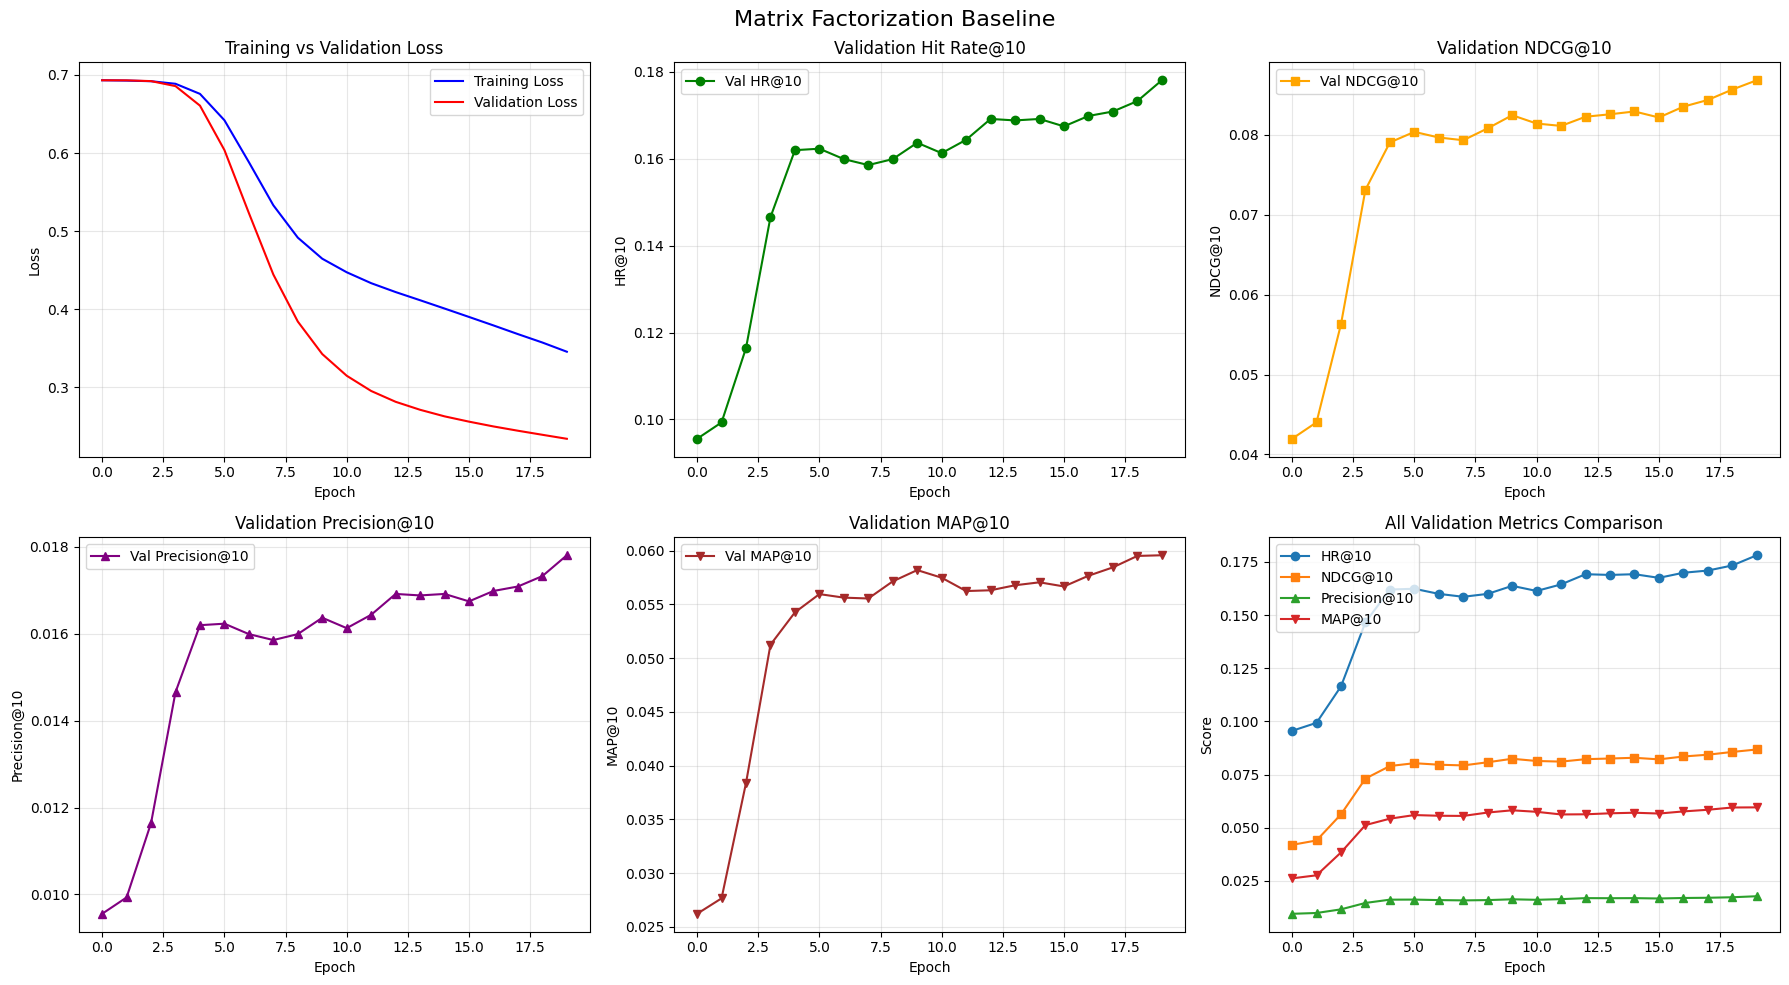

In [25]:
plot_training_history(
    train_losses,
    val_losses,
    val_metrics,
    k=10,
    model_name="Matrix Factorization Baseline",
    save_path="training_history.png"
)

## Testing cross-domain recommendation using the MF baseline

In [28]:
# df_target = load_amazon_reviews_fast("Video_Games", max_items=None, seed=SEED)
# print(f"Target domain data shape: {df_target.shape}")

In [29]:
# data_processor_target = preprocess_dataset(df_target, min_user_interactions=20, min_item_interactions=20)
# filtered_df_target = le
# calculate_data_sparsity(filtered_df_target)

In [ ]:
# train_df_target, val_df_target, test_df_target = loo_split(filtered_df_target, oversample_verified=False, oversample_factor=1)
# print(f"Target domain Train/Validation/Test split: {len(train_df_target)}, {len(val_df_target)}, {len(test_df_target)}")

In [ ]:
# NUM_USERS_TARGET = filtered_df_target["user_id"].max() + 1
# NUM_ITEMS_TARGET = filtered_df_target["item_id"].max() + 1

In [ ]:
# pos_items_by_user_target = build_pos_items_by_user(train_df_target)

In [ ]:
# target_ds_scratch = CustomDataset(train_df_target, num_items=NUM_ITEMS_TARGET, pos_by_user=pos_items_by_user_target, n_neg=4, mode="train", seed=SEED)
# target_loader_scratch = DataLoader(target_ds_scratch, batch_size=4096, shuffle=True)
#
# target_ds_transfer = CustomDataset(val_df_target, num_items=NUM_ITEMS_TARGET, pos_by_user=pos_items_by_user_target, n_neg=99, mode="val", seed=SEED)
# taret_loader_scratch = DataLoader(target_ds_transfer, batch_size=4096, shuffle=False)
#
# target_ds_test = CustomDataset(test_df_target, num_items=NUM_ITEMS_TARGET, pos_by_user=pos_items_by_user_target, n_neg=99, mode="test", seed=SEED)
# target_loader_test = DataLoader(target_ds_test, batch_size=4096, shuffle=False)
#
# print(f"Target domain training dataset created with {len(target_ds_scratch)} samples.")
# print(f"Target domain validation dataset created with {len(target_ds_transfer)} samples.")
# print(f"Target domain test dataset created with {len(target_ds_test)} samples.")

## Model 1: Neural matrix factorization model

In [30]:
class NeuralMF(nn.Module):
    """
    NeuMF: GMF (dot-style) + MLP (nonlinear) with optional user/item/global biases.
    Returns raw logits suitable for BCEWithLogitsLoss.
    """
    def __init__(
        self,
        n_users: int,
        n_items: int,
        gmf_dim: int = 32,
        mlp_dim: int = 32,
        mlp_layers=(64, 32, 16),
        dropout: float = 0.1,
        use_bias: bool = True,
    ):
        super().__init__()
        # GMF branch
        self.user_emb_gmf = nn.Embedding(n_users, gmf_dim)
        self.item_emb_gmf = nn.Embedding(n_items, gmf_dim)

        # MLP branch
        self.user_emb_mlp = nn.Embedding(n_users, mlp_dim)
        self.item_emb_mlp = nn.Embedding(n_items, mlp_dim)

        mlp_blocks = []
        in_dim = mlp_dim * 2
        for h in mlp_layers:
            mlp_blocks.append(nn.Linear(in_dim, h))
            mlp_blocks.append(nn.ReLU())
            if dropout and dropout > 0:
                mlp_blocks.append(nn.Dropout(dropout))
            in_dim = h
        self.mlp = nn.Sequential(*mlp_blocks) if mlp_blocks else nn.Identity()

        # Final combine: concat(GMF, MLP) -> 1
        final_in = gmf_dim + (mlp_layers[-1] if mlp_blocks else mlp_dim * 2)
        self.fc_out = nn.Linear(final_in, 1)

        self.use_bias = use_bias
        if use_bias:
            self.user_bias = nn.Embedding(n_users, 1)
            self.item_bias = nn.Embedding(n_items, 1)
        else:
            self.user_bias = None
            self.item_bias = None
        self.global_bias = nn.Parameter(torch.zeros(1))

        self._reset_parameters()

    def _reset_parameters(self):
        for emb in [self.user_emb_gmf, self.item_emb_gmf, self.user_emb_mlp, self.item_emb_mlp]:
            nn.init.xavier_uniform_(emb.weight)
        for m in self.mlp:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
        nn.init.xavier_uniform_(self.fc_out.weight)
        nn.init.zeros_(self.fc_out.bias)
        if self.use_bias:
            nn.init.zeros_(self.user_bias.weight)
            nn.init.zeros_(self.item_bias.weight)

    def forward(self, user_ids, item_ids):
        # GMF
        gmf_u = self.user_emb_gmf(user_ids)           # [B, gmf_dim]
        gmf_i = self.item_emb_gmf(item_ids)           # [B, gmf_dim]
        gmf   = gmf_u * gmf_i                         # [B, gmf_dim]  (element-wise product)

        # MLP
        mlp_u = self.user_emb_mlp(user_ids)           # [B, mlp_dim]
        mlp_i = self.item_emb_mlp(item_ids)           # [B, mlp_dim]
        mlp   = torch.cat([mlp_u, mlp_i], dim=1)      # [B, 2*mlp_dim]
        mlp   = self.mlp(mlp)                          # [B, last_mlp_hidden]

        # Combine
        x = torch.cat([gmf, mlp], dim=1)              # [B, gmf_dim + last_mlp_hidden]
        logit = self.fc_out(x).squeeze(-1)            # [B]

        if self.use_bias:
            logit = logit + self.user_bias(user_ids).squeeze(-1) + self.item_bias(item_ids).squeeze(-1)
        logit = logit + self.global_bias
        return logit

    @torch.no_grad()
    def predict_all_items(self, user_id: int) -> torch.Tensor:
        """
        Vectorized scoring for all items; returns raw logits.
        """
        device = next(self.parameters()).device
        u = torch.tensor([user_id], dtype=torch.long, device=device)
        all_items = torch.arange(self.item_emb_gmf.num_embeddings, dtype=torch.long, device=device)

        # GMF
        gmf_u = self.user_emb_gmf(u)                          # [1, gmf_dim]
        gmf_i = self.item_emb_gmf(all_items)                  # [N, gmf_dim]
        gmf   = (gmf_u * gmf_i)                               # [N, gmf_dim]

        # MLP
        mlp_u = self.user_emb_mlp(u).expand(all_items.numel(), -1)  # [N, mlp_dim]
        mlp_i = self.item_emb_mlp(all_items)                         # [N, mlp_dim]
        mlp   = torch.cat([mlp_u, mlp_i], dim=1)                     # [N, 2*mlp_dim]
        mlp   = self.mlp(mlp)                                        # [N, last_mlp_hidden]

        x = torch.cat([gmf, mlp], dim=1)                             # [N, gmf_dim+last]
        logit = self.fc_out(x).squeeze(-1)                           # [N]

        if self.use_bias:
            logit = logit + self.user_bias(u).squeeze(-1) + self.item_bias(all_items).squeeze(-1)
        logit = logit + self.global_bias
        return logit

In [31]:
neumf = NeuralMF(
    n_users=NUM_USERS,
    n_items=NUM_ITEMS,
    gmf_dim=32,
    mlp_dim=32,
    mlp_layers=(64, 32, 16),
    dropout=0.2,
    use_bias=True
).to(DEVICE)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(neumf.parameters(), lr=1e-3, weight_decay=1e-6)  # a bit higher LR works well for NeuMF

train_losses_neumf, val_losses_neumf, val_metrics_neumf, best_ndcg_neumf = model_trainer(
    model=neumf,
    train_loader=train_loader,
    eval_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=20,
    k=10,
    device=DEVICE,
    save_dir="model_neumf"
)

best_neumf = load_best_weights(neumf, ckpt_path="model_neumf/best_model.pth", device=DEVICE)
results_neumf = final_evaluation_loader(best_neumf, test_loader, loss_fn, device=DEVICE)

Evaluating: 100%|██████████| 1/1 [00:00<00:00,  6.06it/s]


Epoch 1/20  Train loss 0.6233  Val loss 0.3063  HR@10 0.1449  NDCG@10 0.0711  Precision@10 0.0145  MAP@10 0.0492  (new best)  Time 2.39s


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 15.50it/s]


Epoch 2/20  Train loss 0.5038  Val loss 0.2440  HR@10 0.1582  NDCG@10 0.0782  Precision@10 0.0158  MAP@10 0.0543  (new best)  Time 2.15s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  6.49it/s]


Epoch 3/20  Train loss 0.4766  Val loss 0.2439  HR@10 0.1599  NDCG@10 0.0796  Precision@10 0.0160  MAP@10 0.0556  (new best)  Time 2.17s


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 15.87it/s]


Epoch 4/20  Train loss 0.4681  Val loss 0.2405  HR@10 0.1582  NDCG@10 0.0791  Precision@10 0.0158  MAP@10 0.0554    Time 1.53s


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 13.24it/s]


Epoch 5/20  Train loss 0.4620  Val loss 0.2422  HR@10 0.1613  NDCG@10 0.0816  Precision@10 0.0161  MAP@10 0.0578  (new best)  Time 1.73s


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s]


Epoch 6/20  Train loss 0.4529  Val loss 0.2349  HR@10 0.1582  NDCG@10 0.0801  Precision@10 0.0158  MAP@10 0.0566    Time 1.79s


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 18.51it/s]


Epoch 7/20  Train loss 0.4387  Val loss 0.2365  HR@10 0.1784  NDCG@10 0.0908  Precision@10 0.0178  MAP@10 0.0646  (new best)  Time 1.66s


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 14.49it/s]


Epoch 8/20  Train loss 0.4219  Val loss 0.2275  HR@10 0.1890  NDCG@10 0.0952  Precision@10 0.0189  MAP@10 0.0672  (new best)  Time 1.72s


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 15.63it/s]


Epoch 9/20  Train loss 0.3980  Val loss 0.2212  HR@10 0.2014  NDCG@10 0.1030  Precision@10 0.0201  MAP@10 0.0735  (new best)  Time 2.01s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  9.53it/s]


Epoch 10/20  Train loss 0.3686  Val loss 0.2130  HR@10 0.2199  NDCG@10 0.1140  Precision@10 0.0220  MAP@10 0.0820  (new best)  Time 2.04s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  8.58it/s]


Epoch 11/20  Train loss 0.3340  Val loss 0.2037  HR@10 0.2308  NDCG@10 0.1184  Precision@10 0.0231  MAP@10 0.0846  (new best)  Time 1.95s


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


Epoch 12/20  Train loss 0.3030  Val loss 0.2013  HR@10 0.2360  NDCG@10 0.1175  Precision@10 0.0236  MAP@10 0.0819    Time 1.51s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]


Epoch 13/20  Train loss 0.2734  Val loss 0.1930  HR@10 0.2428  NDCG@10 0.1198  Precision@10 0.0243  MAP@10 0.0828  (new best)  Time 1.94s


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 16.39it/s]


Epoch 14/20  Train loss 0.2489  Val loss 0.1860  HR@10 0.2329  NDCG@10 0.1153  Precision@10 0.0233  MAP@10 0.0799    Time 1.76s


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 14.91it/s]


Epoch 15/20  Train loss 0.2245  Val loss 0.1818  HR@10 0.2370  NDCG@10 0.1183  Precision@10 0.0237  MAP@10 0.0827    Time 1.62s


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 12.82it/s]


Epoch 16/20  Train loss 0.2022  Val loss 0.1789  HR@10 0.2432  NDCG@10 0.1191  Precision@10 0.0243  MAP@10 0.0817    Time 1.57s


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 14.93it/s]


Epoch 17/20  Train loss 0.1836  Val loss 0.1752  HR@10 0.2360  NDCG@10 0.1164  Precision@10 0.0236  MAP@10 0.0804    Time 1.69s


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 10.85it/s]


Epoch 18/20  Train loss 0.1648  Val loss 0.1762  HR@10 0.2325  NDCG@10 0.1146  Precision@10 0.0233  MAP@10 0.0791    Time 1.63s


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 18.17it/s]


Epoch 19/20  Train loss 0.1490  Val loss 0.1709  HR@10 0.2298  NDCG@10 0.1139  Precision@10 0.0230  MAP@10 0.0789    Time 1.69s


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 16.76it/s]


Epoch 20/20  Train loss 0.1346  Val loss 0.1661  HR@10 0.2336  NDCG@10 0.1135  Precision@10 0.0234  MAP@10 0.0774    Time 1.64s

Training Complete.
Best epoch: 13 with NDCG@10: 0.1198



Evaluating: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


     HR@K  NDCG@K  Precision@K
K                             
5  0.1247  0.0753       0.0249
10 0.2123  0.1034       0.0212
20 0.3589  0.1400       0.0179
50 0.6253  0.1927       0.0125


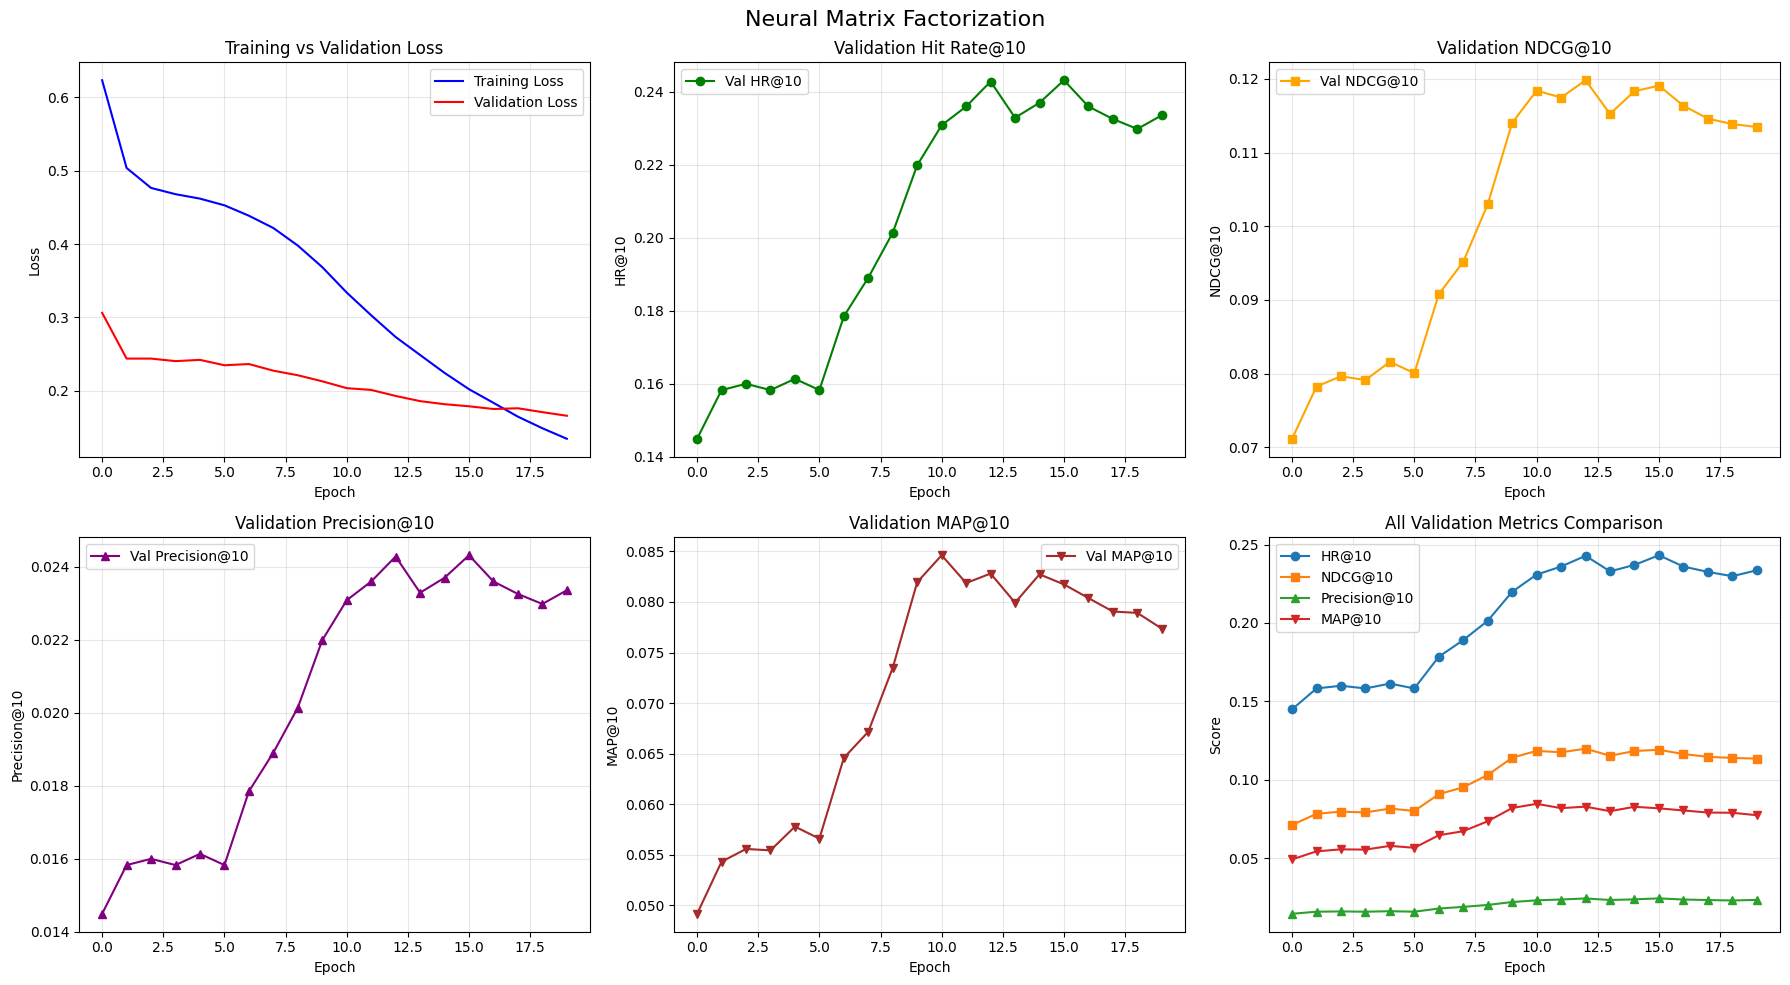

In [32]:
plot_training_history(
    train_losses_neumf,
    val_losses_neumf,
    val_metrics_neumf,
    k=10,
    model_name="Neural Matrix Factorization",
    save_path="training_history_neumf.png"
)

## Model 2: SASRec model
Transformer-based model for sequential recommendation from the paper [Self-Attentive Sequential Recommendation (2018)](https://arxiv.org/abs/1808.09781).

* **Data:** build per-user, time-sorted history sequences (left-padded to max length in batch). For training, use history -> next item triples + one negative per triples.
* **Model:** Item embeddings + positional embeddings -> Transformer encoder with causal mask. Take final position representation as the user's state and score candidate items by dot-product.
* **Eval:** Identical to the baseline using LOO setting.

In [33]:
def create_user_sequences(df):
    df_sorted = df.sort_values(["user_id", "timestamp"])
    user_sequences = {}
    user_seq_lens = []
    for uid, group in tqdm(df_sorted.groupby("user_id"), desc="Building user sequences"):
        items = group["item_id"].tolist()
        if len(items) >= 3:  # Need at least 3 for train/val/test split
            user_sequences[uid] = items
            user_seq_lens.append(len(items))

    print(f"Created sequences for {len(user_sequences)} users.")
    print(f"Average sequence length: {np.mean(user_seq_lens):.2f}")
    print(f"Max sequence length: {np.max(user_seq_lens)}")
    print(f"Min sequence length: {np.min(user_seq_lens)}")

    return {
        "sequences": user_sequences,
        "avg_seq_len": np.mean(user_seq_lens),
        "num_users": len(user_sequences)
    }

class SASRecDataset(Dataset):
    def __init__(self, user_sequences, num_items, max_seq_len=50, mode="train", neg_samples=1):
        self.user_sequences = user_sequences
        self.num_items = num_items
        self.max_seq_len = max_seq_len
        self.mode = mode
        self.neg_samples = neg_samples

        # Convert to list for indexing
        self.users = list(user_sequences.keys())

        # Build set of all items each user has interacted with (for negative sampling)
        self.user_item_set = {
            u: set(items) for u, items in user_sequences.items()
        }

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        user = self.users[idx]
        seq = self.user_sequences[user]

        if self.mode == "train":
            # For training: use all but last to predict item
            # input_seq = seq[:-2] if len(seq) > 2 else seq[:-1]
            # target = seq[-2] if len(seq) > 2 else seq[-1]
            t = random.randint(1, len(seq) - 1)  # at least one item in input
            input_seq = seq[:t]
            target = seq[t]
        elif self.mode == "val":
            # For validation: use all but last item to predict second-to-last
            input_seq = seq[:-2]
            target = seq[-2]
        else:  # test
            # For test: use all but last to predict last
            input_seq = seq[:-1]
            target = seq[-1]

        # Pad sequence to max_seq_len
        input_seq = self._process_sequence(input_seq)

        # Sample negative items
        neg_items = self._sample_negatives(user)

        return {
            "user": user,
            "input_seq": torch.tensor(input_seq, dtype=torch.long),
            "target": torch.tensor(target, dtype=torch.long), # target is a single item
            "neg_items": torch.tensor(neg_items, dtype=torch.long)
        }

    def _process_sequence(self, seq):
        if len(seq) > self.max_seq_len:
            # Keep only the most recent max_seq_len items
            seq = seq[-self.max_seq_len:]
        elif len(seq) < self.max_seq_len:
            # Pad with zeros at the beginning
            seq = [0] * (self.max_seq_len - len(seq)) + seq
        return seq

    def _sample_negatives(self, user):
        neg_items = []
        user_items = self.user_item_set[user]
        while len(neg_items) < self.neg_samples:
            neg = random.randint(1, self.num_items - 1)
            if neg not in user_items:
                neg_items.append(neg)
        return neg_items

user_sequences = create_user_sequences(filtered_df)

# Use the same train/val/test split as before
train_users = set(train_df["user_id"].unique())
val_users = set(val_df["user_id"].unique())
test_users = set(test_df["user_id"].unique())

# Filter user sequences to match the splits
train_sequences = {u: seq for u, seq in user_sequences["sequences"].items() if u in train_users}
val_sequences = {u: seq for u, seq in user_sequences["sequences"].items() if u in val_users}
test_sequences = {u: seq for u, seq in user_sequences["sequences"].items() if u in test_users}

print(f"Train sequences: {len(train_sequences)} users")
print(f"Validation sequences: {len(val_sequences)} users")
print(f"Test sequences: {len(test_sequences)} users")

Building user sequences: 100%|██████████| 3286/3286 [00:00<00:00, 34576.97it/s]

Created sequences for 3133 users.
Average sequence length: 14.59
Max sequence length: 180
Min sequence length: 3
Train sequences: 3133 users
Validation sequences: 2920 users
Test sequences: 2920 users


In [34]:
train_dataset_sasrec = SASRecDataset(train_sequences, num_items=NUM_ITEMS, max_seq_len=50, mode="train", neg_samples=1)
val_dataset_sasrec = SASRecDataset(val_sequences, num_items=NUM_ITEMS, max_seq_len=50, mode="val", neg_samples=99)
test_dataset_sasrec = SASRecDataset(test_sequences, num_items=NUM_ITEMS, max_seq_len=50, mode="test", neg_samples=99)

train_loader_sasrec = DataLoader(train_dataset_sasrec, batch_size=4096, shuffle=True)
val_loader_sasrec = DataLoader(val_dataset_sasrec, batch_size=4096, shuffle=False)
test_loader_sasrec = DataLoader(test_dataset_sasrec, batch_size=4096, shuffle=False)

print(f"SASRec training dataset created with {len(train_dataset_sasrec)} samples.")
print(f"SASRec validation dataset created with {len(val_dataset_sasrec)} samples.")
print(f"SASRec test dataset created with {len(test_dataset_sasrec)} samples.")

SASRec training dataset created with 3133 samples.
SASRec validation dataset created with 2920 samples.
SASRec test dataset created with 2920 samples.


In [35]:
first = next(iter(train_loader_sasrec))
print("Shapes:",
      first["input_seq"].shape,   # expect [B, L]
      first["target"].shape,      # [B]
      first["neg_items"].shape,   # [B, N] (N==neg_samples or padded)
      first["user"].shape)        # [B]

Shapes: torch.Size([3133, 50]) torch.Size([3133]) torch.Size([3133, 1]) torch.Size([3133])


### Building the model

In [36]:
# Building SASRec model
class PointWiseFeedForward(nn.Module):
    def __init__(self, hidden_dim, dropout=0.2):
        super().__init__()
        self.w1 = nn.Linear(hidden_dim, hidden_dim)
        self.w2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w2(self.dropout(self.relu(self.w1(x))))

class AttentionBlock(nn.Module):
    def __init__(self, hidden_dim, num_heads, dropout=0.2):
        super().__init__()

        # Multi-head attention
        self.attn = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout, batch_first=True)

        # Layer norms
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)

        # Feed-forward network
        self.ffn = PointWiseFeedForward(hidden_dim, dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, attn_mask=None):
        # Self-attention with residual connection
        attn_out, _ = self.attn(x, x, x, attn_mask=attn_mask)
        x = self.ln1(x + self.dropout(attn_out))

        # Feed-forward network with residual connection
        ffn_out = self.ffn(x)
        x = self.ln2(x + self.dropout(ffn_out))

        return x

class SASRec(nn.Module):
    def __init__(self,
                 num_items,
                 hidden_dim=64,
                 max_seq_len=50,
                 num_blocks=2,
                 num_heads=2,
                 dropout=0.2):
        super().__init__()

        self.num_items = num_items
        self.hidden_dim = hidden_dim
        self.max_seq_len = max_seq_len

        # Embedding layers
        self.item_embed = nn.Embedding(num_items, hidden_dim, padding_idx=0)
        self.positional_embed = nn.Embedding(max_seq_len, hidden_dim)
        self.dropout = nn.Dropout(dropout)

        # Stack of SASRec blocks
        self.blocks = nn.ModuleList([
            AttentionBlock(hidden_dim, num_heads, dropout) for _ in range(num_blocks)
        ])

        # Final layer norm
        self.ln = nn.LayerNorm(hidden_dim)

        # Initialize weights
        self._reset_parameters()

    def _reset_parameters(self):
        nn.init.xavier_normal_(self.item_embed.weight[1:])  # Skip padding idx
        nn.init.xavier_normal_(self.positional_embed.weight)

    def forward(self, input_seq, candidate_items=None):
        batch_size, seq_len = input_seq.shape

        # Get item embeddings
        item_embeds = self.item_embed(input_seq)  # [B, L, D]

        # Add positional embeddings
        positions = torch.arange(seq_len, device=input_seq.device).unsqueeze(0)
        pos_embeds = self.positional_embed(positions)  # [1, L, D]
        x = self.dropout(item_embeds + pos_embeds)

        # Create causal attention mask
        attn_mask = self._create_causal_mask(seq_len, input_seq.device)

        # Pass through transformer blocks
        for block in self.blocks:
            x = block(x, attn_mask=attn_mask)

        # Final layer norm
        x = self.ln(x)  # [B, L, D]

        # If candidate_items provided, score them
        if candidate_items is not None:
            # Get embeddings for candidate items
            cand_emb = self.item_embed(candidate_items) # [B, N, D]

            # Use last position's representation for scoring
            last_hidden = x[:, -1, :].unsqueeze(1)  # [B, 1, D]

            # Compute scores via dot product
            scores = torch.matmul(last_hidden, cand_emb.transpose(1, 2)).squeeze(1) # [B, N]
            return scores

        return x

    def _create_causal_mask(self, seq_len, device):
        mask = torch.triu(torch.ones(seq_len, seq_len, device=device), diagonal=1)
        mask = mask.masked_fill(mask == 1, float("-inf"))
        return mask

    def predict_next(self, input_seq):
        # Get sequence representations
        seq_repr = self.forward(input_seq)  # [B, L, D]

        # Use last position for prediction
        last_hidden = seq_repr[:, -1, :]  # [B, D]

        # Score against all item embeddings
        all_item_embeds = self.item_embed.weight  # [num_items, D]
        scores = torch.matmul(last_hidden, all_item_embeds.T)  # [B, num_items]
        return scores

### Training the SASRec model

In [37]:
def train_sasrec_epoch(model, train_loader, loss_fn, optimizer, device="cpu"):
    model.train()
    total_loss = 0.0
    n_batches = 0

    for batch in tqdm(train_loader, desc="Training"):
        input_seq = batch["input_seq"].to(device)
        pos_items = batch["target"].to(device)
        neg_items = batch["neg_items"].to(device)

        # Get predictions for last position
        seq_output = model(input_seq)  # [B, L, D]
        last_hidden = seq_output[:, -1, :]  # [B, D]

        # Get embeddings for positive and negative items
        pos_embeds = model.item_embed(pos_items)
        neg_embeds = model.item_embed(neg_items)

        # Compute logits
        pos_logits = (last_hidden * pos_embeds).sum(dim=1)
        neg_logits = torch.bmm(neg_embeds, last_hidden.unsqueeze(-1)).squeeze(-1)

        # Binary cross-entropy loss with logits
        pos_labels = torch.ones_like(pos_logits)
        neg_labels = torch.zeros_like(neg_logits)

        # Concatenate logits and labels
        all_logits = torch.cat([pos_logits.unsqueeze(1), neg_logits], dim=1)
        all_labels = torch.cat([pos_labels.unsqueeze(1), neg_labels], dim=1)

        loss = loss_fn(all_logits, all_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        n_batches += 1

    return total_loss / n_batches

# Validation loss and ranking metrics
@torch.no_grad()
def evaluate_sasrec(model, eval_loader, loss_fn, k=10, device="cpu"):
    model.eval()
    total = 0
    sum_hr = 0.0
    sum_ndcg = 0.0
    sum_prec = 0.0
    sum_ap = 0.0

    sum_val_loss = 0.0
    n_loss_batches = 0

    for batch in tqdm(eval_loader, desc="Evaluating"):
        input_seq = batch["input_seq"].to(device)
        target = batch["target"].to(device)
        neg_items = batch["neg_items"].to(device)

        batch_size = input_seq.size(0)

        # Create candidate set: 1 positive + negatives
        seq_output = model(input_seq)  # [B, L, D]
        last_hidden = seq_output[:, -1, :]  # [B, D]
        candidates = torch.cat([
            target.unsqueeze(1),  # [B, 1]
            neg_items  # [B, neg_samples]
        ], dim=1)  # [B, 1 + neg_samples]

        # Get embeddings for all candidates
        cand_emb = model.item_embed(candidates)  # [B, 1+neg_samples, D]

        # Compute scores via dot product
        scores = torch.bmm(cand_emb, last_hidden.unsqueeze(-1)).squeeze(-1)  # [B, 1+neg_samples]

        # Loss calculation
        pos_scores = scores[:, 0]
        neg_scores = scores[:, 1:]
        pos_labels = torch.ones_like(scores[:, 0])
        neg_labels = torch.zeros_like(scores[:, 1:])
        all_scores = torch.cat([pos_scores.unsqueeze(1), neg_scores], dim=1)
        all_labels = torch.cat([pos_labels.unsqueeze(1), neg_labels], dim=1)
        batch_loss = loss_fn(all_scores.reshape(-1), all_labels.reshape(-1))
        sum_val_loss += batch_loss.item()
        n_loss_batches += 1

        # Calculate metrics
        _, full_idx = torch.sort(scores, dim=1, descending=True)
        rank = (full_idx == 0).nonzero(as_tuple=True)[1] + 1  # Rank of the positive item (1-based)

        hit = (rank <= k).float()
        ndcg = torch.where(rank <= k, 1.0 / torch.log2(rank.float() + 1), torch.zeros_like(hit))
        precision = hit / float(k)
        ap = torch.where(rank <= k, 1.0 / rank.float(), torch.zeros_like(hit))

        sum_hr += hit.sum().item()
        sum_ndcg += ndcg.sum().item()
        sum_prec += precision.sum().item()
        sum_ap += ap.sum().item()
        total += batch_size

    metrics = {
        "HR@K": sum_hr / total if total else 0.0,
        "NDCG@K": sum_ndcg / total if total else 0.0,
        "Precision@K": sum_prec / total if total else 0.0,
        "MAP@K": sum_ap / total if total else 0.0,
        "Val loss": sum_val_loss / max(n_loss_batches, 1)
    }

    return metrics

In [38]:
def sasrec_trainer(
        model,
        train_loader,
        eval_loader,
        epochs,
        loss_fn,
        optimizer,
        k=10,             # kept to log hyperparams
        device="cpu",
        save_dir="model"
    ):
    os.makedirs(save_dir, exist_ok=True)
    model.to(device)
    writer = SummaryWriter()

    train_losses, val_losses, val_metrics_log = [], [], []
    best_ndcg, best_epoch = 0.0, 0

    for epoch in range(epochs):
        t0 = time.time()

        # Train (batched)
        train_loss = train_sasrec_epoch(model, train_loader, loss_fn, optimizer, device=device)
        train_losses.append(train_loss)

        # Eval (batched)
        m = evaluate_sasrec(model, eval_loader, loss_fn, k=k, device=device)
        val_losses.append(m["Val loss"])
        val_metrics_log.append({k_: m[k_] for k_ in ["HR@K", "NDCG@K", "Precision@K", "MAP@K"]})

        # Checkpointing by NDCG
        if m["NDCG@K"] > best_ndcg:
            best_ndcg = m["NDCG@K"]
            best_epoch = epoch + 1
            torch.save(model.state_dict(), os.path.join(save_dir, "best_model.pth"))
        torch.save(model.state_dict(), os.path.join(save_dir, "last_model.pth"))

        # TB logs
        writer.add_scalar("Loss/Train", train_loss, epoch)
        writer.add_scalar("Loss/Validation", m["Val loss"], epoch)
        writer.add_scalar(f"Metrics/Val_HR@{k}", m["HR@K"], epoch)
        writer.add_scalar(f"Metrics/Val_NDCG@{k}", m["NDCG@K"], epoch)
        writer.add_scalar(f"Metrics/Val_Precision@{k}", m["Precision@K"], epoch)
        writer.add_scalar(f"Metrics/Val_MAP@{k}", m["MAP@K"], epoch)

        print(
            f"Epoch {epoch+1}/{epochs}  "
            f"Train loss {train_loss:.4f}  "
            f"Val loss {m['Val loss']:.4f}  "
            f"HR@{k} {m['HR@K']:.4f}  "
            f"NDCG@{k} {m['NDCG@K']:.4f}  "
            f"Precision@{k} {m['Precision@K']:.4f}  "
            f"MAP@{k} {m['MAP@K']:.4f}  "
            f"{'(new best)' if m['NDCG@K'] == best_ndcg and best_epoch==epoch+1 else ''}  "
            f"Time {time.time()-t0:.2f}s"
        )

    # print("\n" + "="*50)
    print("\nTraining Complete.")
    print(f"Best epoch: {best_epoch} with NDCG@{k}: {best_ndcg:.4f}\n")
    # print("="*50)
    # print("\n")

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    writer.close()
    return train_losses, val_losses, val_metrics_log, best_ndcg

In [39]:
# Hyperparameters from the original paper, except higher hidden_dim
sasrec = SASRec(
    num_items=NUM_ITEMS,
    hidden_dim=64,
    max_seq_len=50,
    num_blocks=2,
    num_heads=2,
    dropout=0.5
)

loss_fn_sasrec = nn.BCEWithLogitsLoss()
optimizer_sasrec = torch.optim.Adam(sasrec.parameters(), lr=1e-3, weight_decay=1e-6)

train_losses_sasrec, val_losses_sasrec, val_metrics_sasrec, best_ndcg_sasrec = sasrec_trainer(
    model=sasrec,
    train_loader=train_loader_sasrec,
    eval_loader=val_loader_sasrec,
    loss_fn=loss_fn_sasrec,
    optimizer=optimizer_sasrec,
    epochs=20,
    k=10,
    device=DEVICE,
    save_dir="model_sasrec"
)

Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


Epoch 1/20  Train loss 0.6934  Val loss 0.6939  HR@10 0.1178  NDCG@10 0.0554  Precision@10 0.0118  MAP@10 0.0369  (new best)  Time 1.04s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


Epoch 2/20  Train loss 0.6933  Val loss 0.6938  HR@10 0.1271  NDCG@10 0.0596  Precision@10 0.0127  MAP@10 0.0397  (new best)  Time 0.73s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


Epoch 3/20  Train loss 0.6936  Val loss 0.6938  HR@10 0.1370  NDCG@10 0.0643  Precision@10 0.0137  MAP@10 0.0428  (new best)  Time 0.75s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


Epoch 4/20  Train loss 0.6918  Val loss 0.6936  HR@10 0.1432  NDCG@10 0.0669  Precision@10 0.0143  MAP@10 0.0441  (new best)  Time 0.96s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


Epoch 5/20  Train loss 0.6915  Val loss 0.6934  HR@10 0.1586  NDCG@10 0.0739  Precision@10 0.0159  MAP@10 0.0488  (new best)  Time 0.80s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Epoch 6/20  Train loss 0.6898  Val loss 0.6930  HR@10 0.1634  NDCG@10 0.0776  Precision@10 0.0163  MAP@10 0.0521  (new best)  Time 0.78s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


Epoch 7/20  Train loss 0.6887  Val loss 0.6928  HR@10 0.1702  NDCG@10 0.0807  Precision@10 0.0170  MAP@10 0.0541  (new best)  Time 0.79s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


Epoch 8/20  Train loss 0.6883  Val loss 0.6924  HR@10 0.1836  NDCG@10 0.0867  Precision@10 0.0184  MAP@10 0.0579  (new best)  Time 0.81s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Epoch 9/20  Train loss 0.6869  Val loss 0.6923  HR@10 0.1860  NDCG@10 0.0898  Precision@10 0.0186  MAP@10 0.0611  (new best)  Time 0.81s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


Epoch 10/20  Train loss 0.6861  Val loss 0.6918  HR@10 0.1949  NDCG@10 0.0942  Precision@10 0.0195  MAP@10 0.0643  (new best)  Time 0.78s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


Epoch 11/20  Train loss 0.6848  Val loss 0.6914  HR@10 0.1962  NDCG@10 0.0945  Precision@10 0.0196  MAP@10 0.0640  (new best)  Time 0.77s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]


Epoch 12/20  Train loss 0.6826  Val loss 0.6910  HR@10 0.2027  NDCG@10 0.0961  Precision@10 0.0203  MAP@10 0.0643  (new best)  Time 0.96s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


Epoch 13/20  Train loss 0.6820  Val loss 0.6907  HR@10 0.2010  NDCG@10 0.0976  Precision@10 0.0201  MAP@10 0.0666  (new best)  Time 0.79s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


Epoch 14/20  Train loss 0.6813  Val loss 0.6900  HR@10 0.2065  NDCG@10 0.0989  Precision@10 0.0207  MAP@10 0.0666  (new best)  Time 0.80s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Epoch 15/20  Train loss 0.6791  Val loss 0.6895  HR@10 0.2110  NDCG@10 0.1026  Precision@10 0.0211  MAP@10 0.0703  (new best)  Time 0.76s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


Epoch 16/20  Train loss 0.6759  Val loss 0.6890  HR@10 0.2116  NDCG@10 0.1023  Precision@10 0.0212  MAP@10 0.0696    Time 0.68s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


Epoch 17/20  Train loss 0.6771  Val loss 0.6886  HR@10 0.2120  NDCG@10 0.1045  Precision@10 0.0212  MAP@10 0.0724  (new best)  Time 0.82s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


Epoch 18/20  Train loss 0.6765  Val loss 0.6885  HR@10 0.2195  NDCG@10 0.1067  Precision@10 0.0220  MAP@10 0.0729  (new best)  Time 0.81s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


Epoch 19/20  Train loss 0.6723  Val loss 0.6878  HR@10 0.2236  NDCG@10 0.1099  Precision@10 0.0224  MAP@10 0.0760  (new best)  Time 0.81s


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Epoch 20/20  Train loss 0.6697  Val loss 0.6875  HR@10 0.2250  NDCG@10 0.1112  Precision@10 0.0225  MAP@10 0.0772  (new best)  Time 1.04s

Training Complete.
Best epoch: 20 with NDCG@10: 0.1112



### Final evaluation on test set

In [40]:
best_sasrec = load_best_weights(sasrec, ckpt_path="model_sasrec/best_model.pth", device=DEVICE)

In [41]:
# Final evaluation on test set
@torch.no_grad()
def final_evaluation_sasrec(model, test_loader, loss_fn, k_values=(5,10,20,50), device="cpu") -> pd.DataFrame:
    rows = []
    for k in k_values:
        metrics = evaluate_sasrec(model, test_loader, loss_fn, k=k, device=device)
        rows.append({
            "K": k,
            "HR@K": metrics["HR@K"],
            "NDCG@K": metrics["NDCG@K"],
            "Precision@K": metrics["Precision@K"],
        })
    df = pd.DataFrame(rows).set_index("K").sort_index()
    print(df.to_string(float_format=lambda x: f"{x:.4f}"))
    return df

results_df_sasrec = final_evaluation_sasrec(best_sasrec, test_loader_sasrec, loss_fn_sasrec, device=DEVICE)

Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]

     HR@K  NDCG@K  Precision@K
K                             
5  0.1253  0.0739       0.0251
10 0.2164  0.1021       0.0216
20 0.3798  0.1433       0.0190
50 0.7096  0.2068       0.0142


In [42]:
@torch.no_grad()
def get_recommendations_sasrec(
        model,
        user_id,
        input_seq,
        pos_items_by_user,
        item_encoder,
        top_k=10,
        exclude_interacted=True,
        device="cpu"):

    model.eval()

    if len(input_seq) > model.max_seq_len:
        processed_seq = input_seq[-model.max_seq_len:]
    elif len(input_seq) < model.max_seq_len:
        processed_seq = [0] * (model.max_seq_len - len(input_seq)) + input_seq
    else:
        processed_seq = input_seq

    input_tensor = torch.tensor([processed_seq], dtype=torch.long, device=device)
    scores = model.predict_next(input_tensor).squeeze(0)

    # Exclude items the user has already interacted with
    if exclude_interacted and user_id in pos_items_by_user:
        interacted_indices = torch.as_tensor(
            list(pos_items_by_user[user_id]),
            dtype=torch.long,
            device=device
        )
        if interacted_indices.numel() > 0:
            scores.index_fill_(0, interacted_indices, float("-inf"))

    top_scores, top_indices = torch.topk(scores, top_k)
    item_ids_np = top_indices.detach().cpu().numpy()
    items_np = item_encoder.inverse_transform(item_ids_np)

    return [
        {"item_id": int(i), "item": it, "score": float(s)}
        for i, it, s in zip(item_ids_np, items_np, top_scores.detach().cpu().numpy())
    ]

In [43]:
def show_sample_recommendations_sasrec(
    model,
    df,
    user_encoder,
    item_encoder,
    pos_items_by_user,    # Used for filtering recommendations
    history_by_user,      # Used to get the input sequence for the model
    device,
    num_users=5,
    top_k=10):

    print("\n" + "="*50)
    print("SASRec - User Sample Recommendations")
    print("="*50)

    user_candidates = df["user_id"].unique().tolist()
    num_to_sample = min(num_users, len(user_candidates))

    for user_id in random.sample(user_candidates, k=num_to_sample):
        original_user = user_encoder.inverse_transform([user_id])[0]
        print(f"\nUser: {original_user} (ID: {user_id})")
        print("-" * 40)

        # Get the user's interaction history to show and to use as model input
        user_history_seq = history_by_user.get(user_id, [])

        # Display the 5 most recent interactions
        recent_interactions = user_history_seq[-5:]
        print("Recent interactions (most recent first):")
        for item_id in reversed(recent_interactions):
            item_name = item_encoder.inverse_transform([item_id])[0]
            print(f"  - {item_name} (ID: {item_id})")

        # Get recommendations using the adapted function
        recs = get_recommendations_sasrec(
            model=model,
            user_id=user_id,
            input_seq=user_history_seq, # Pass the full history as input
            pos_items_by_user=pos_items_by_user,
            item_encoder=item_encoder,
            device=device,
            top_k=top_k,
            exclude_interacted=True
        )

        print("\nTop 10 Recommendations:")
        for i, rec in enumerate(recs, 1):
            print(f"  {i}. {rec['item']} (ID: {rec['item_id']}, Score: {rec['score']:.4f})")

In [44]:
show_sample_recommendations_sasrec(
    model=best_sasrec,
    df=filtered_df,
    user_encoder=user_enc,
    item_encoder=item_enc,
    pos_items_by_user=pos_items_by_user,
    history_by_user=history_by_user_train,
    device=DEVICE,
    num_users=5,
    top_k=10
)


SASRec - User Sample Recommendations

User: AHK5IQX6MXRKJDVSOPHNQ4N2CAUQ (ID: 2861)
----------------------------------------
Recent interactions (most recent first):
  - B077HP62ZQ (ID: 15338)
  - B06XRVMJCB (ID: 14803)
  - B000SW4DLM (ID: 3777)
  - B008Y6ZXR2 (ID: 8606)
  - B003DNN0L2 (ID: 6018)

Top 10 Recommendations:
  1. B07C167TN8 (ID: 15601, Score: 0.9676)
  2. B07MXK64BY (ID: 16050, Score: 0.8515)
  3. B00M0JU1XU (ID: 11453, Score: 0.7996)
  4. B07KLS2X4F (ID: 15969, Score: 0.7830)
  5. B00006FDCD (ID: 1392, Score: 0.7779)
  6. B018FK66TU (ID: 13392, Score: 0.7731)
  7. B00003CX9W (ID: 567, Score: 0.7510)
  8. B07193L7RD (ID: 14895, Score: 0.7504)
  9. B00RGZ94SG (ID: 12087, Score: 0.7286)
  10. B008JFUO36 (ID: 8380, Score: 0.7259)

User: AFE5THYJU2EH2H5NSMTMKF6WK3WA (ID: 1059)
----------------------------------------
Recent interactions (most recent first):
  - B00DZP1C9K (ID: 10091)
  - B001LXIDVI (ID: 4802)
  - B00MH8DU9Q (ID: 11539)
  - B001AEF6BI (ID: 4381)
  - B002SAMMEC

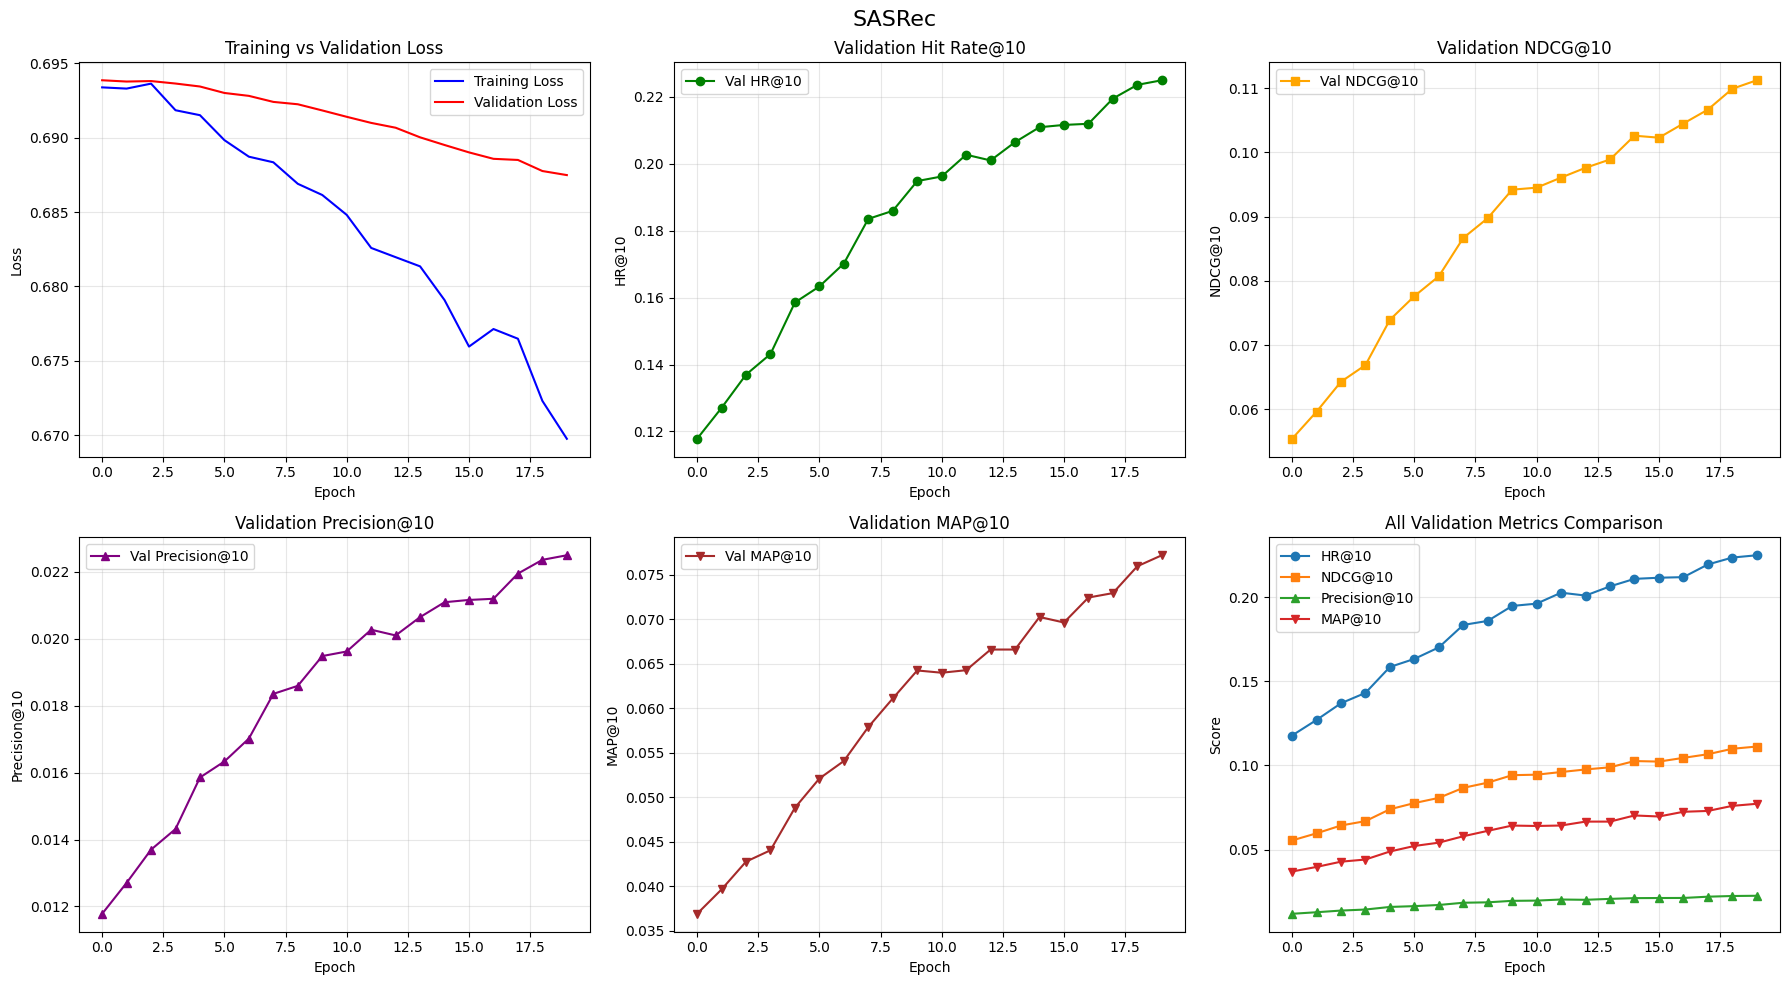

In [45]:
plot_training_history(
    train_losses_sasrec,
    val_losses_sasrec,
    val_metrics_sasrec,
    k=10,
    model_name="SASRec",
    save_path="training_history_sasrec.png"
)

## Cross-domain recommendation development

In [ ]:
# New input
SOURCE_DOMAIN = "Books"
TARGET_DOMAIN = "Movies_and_TV"
ALL_DOMAIN = [SOURCE_DOMAIN, TARGET_DOMAIN]

# Loading data from multiple domains
all_dfs = []
for domain in ALL_DOMAIN:
    df_domain = load_amazon_reviews_fast(domain, max_items=5_000_000, seed=SEED)
    print(f"{domain} domain data shape: {df_domain.shape}")
    all_dfs.append(df_domain)

combined_df = pd.concat(all_dfs, ignore_index=True)
print(f"Total interactions across domains: {len(combined_df)}")

# Preprocess the combined dataset
data_processor_combined = preprocess_dataset(combined_df, min_user_interactions=20, min_item_interactions=20)